In [1]:
# loading packages

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2


Data Builder Class

In [35]:
class MRINoiseDatasetBuilder:
    def __init__(self, input_dir, output_dir, sigma_range=(0.1, 0.3), 
                 num_noise_levels=5, use_augmentation=True, 
                 rotation_angles=[0, 90, 180, 270], use_flips=True, 
                 small_rotation_range=10, seed=42):
        """
        Build MRI denoising dataset with full 512x512 images and augmentation
        
        Args:
            input_dir: Directory containing clean MRI images
            output_dir: Directory to save the dataset
            sigma_range: Tuple of (min_sigma, max_sigma) for noise levels
            num_noise_levels: Number of different noise levels per image
            use_augmentation: Whether to apply geometric augmentations
            rotation_angles: List of rotation angles in degrees [0, 90, 180, 270]
            use_flips: Whether to apply horizontal/vertical flips
            small_rotation_range: Range for small random rotations (±degrees)
            seed: Random seed for reproducibility
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.sigma_range = sigma_range
        self.num_noise_levels = num_noise_levels
        self.use_augmentation = use_augmentation
        self.rotation_angles = rotation_angles
        self.use_flips = use_flips
        self.small_rotation_range = small_rotation_range
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        os.makedirs(self.output_dir, exist_ok=True)
    
    def build(self):
        """Build the complete dataset"""
        image_files = sorted([
            f for f in os.listdir(self.input_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))
        ])
        
        if not image_files:
            raise ValueError(f"No image files found in {self.input_dir}")
        
        print(f"Found {len(image_files)} images")
        print(f"Sigma range: {self.sigma_range}")
        print(f"Noise levels per image: {self.num_noise_levels}")
        
        clean_images = []
        noisy_images = []
        all_sigmas = []
        noise_tensors = []
        
        sigma_min, sigma_max = self.sigma_range
        
        for idx, fname in enumerate(image_files):
            #print(f"Processing {fname} ({idx+1}/{len(image_files)})")
            
            try:
                path = os.path.join(self.input_dir, fname)
                base_image = self._load_image(path)
                
                # Get all augmented versions of this image
                augmented_images = self._get_augmented_images(base_image)
                #print(f"  Generated {len(augmented_images)} augmented versions")
                
                # For each augmented image, create multiple noise levels
                for aug_image in augmented_images:
                    # Normalize the augmented image
                    clean_normalized = self._z_score_normalize(aug_image)
                    
                    # 1. Always add one perfectly clean version
                    clean_tensor = torch.tensor(clean_normalized, dtype=torch.float32).unsqueeze(0)
                    clean_images.append(clean_tensor)
                    noisy_images.append(clean_tensor)
                    all_sigmas.append(torch.tensor([0.0], dtype=torch.float32))
    
                    # Generate multiple noise levels for this augmented image
                    sigmas = np.random.uniform(sigma_min, sigma_max, self.num_noise_levels)
                    
                    
                    for sigma in sigmas:
                        noise = np.random.normal(0, sigma, clean_normalized.shape).astype(np.float32)
                        noisy_image = clean_normalized + noise
    
                        # Store components separately
                        clean_tensor = torch.tensor(clean_normalized, dtype=torch.float16).unsqueeze(0)
                        noise_tensor = torch.tensor(noise, dtype=torch.float16).unsqueeze(0)
    
                        clean_images.append(clean_tensor)
                        noise_tensors.append(noise_tensor)  # Store noise separately
                        all_sigmas.append(torch.tensor([sigma], dtype=torch.float16))
                    
            except Exception as e:
                print(f"Error processing {fname}: {e}")
                continue
        
        if not clean_images:
            raise ValueError("No valid images were processed")
        
        
        # Save dataset
        dataset_path = os.path.join(self.output_dir, 'mri_denoising_dataset.pt')
        torch.save({
            'clean_images': clean_images,
            'noise_tensors': noise_tensors,
            'sigmas': torch.cat(all_sigmas),
            'sigma_range': self.sigma_range,
            'num_samples': len(clean_images),
            'image_shape': (512, 512)
        }, dataset_path)
        
        print(f"\nDataset saved to: {dataset_path}")
        print(f"Total samples: {len(clean_images)}")
        #print(f"Clean images shape: {clean_images.shape}")
        #print(f"Noisy images shape: {noisy_tensor.shape}")
        #print(f"Sigmas shape: {all_sigmas_tensor.shape}")
        
        # Print some statistics
        #self._print_dataset_stats(clean_images, noise_tensor)
        
        return dataset_path
    
    def _load_image(self, path):
        """Load image and convert to float32 [0,1] range"""
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {path}")
        
        if img.shape != (512, 512):
            raise ValueError(f"Image {path} must be 512x512, got {img.shape}")
        
        # Convert to float32 and normalize to [0,1]
        return img.astype(np.float32) / 255.0
    
    def _get_augmented_images(self, image):
        """Generate augmented versions of the input image"""
        augmented = []
        
        if not self.use_augmentation:
            return [image]  # Just return original
        
        # 1. Original image
        augmented.append(image)
        
        # 2. 90-degree rotations
        for angle in self.rotation_angles[1:]:  # Skip 0 degrees (original)
            rotated = self._rotate_image(image, angle)
            augmented.append(rotated)
        
        # 3. Flips (apply to original and one rotation to avoid too many)
        if self.use_flips:
            # Horizontal flip
            flipped_h = np.fliplr(image)
            augmented.append(flipped_h)
            
            # Vertical flip  
            flipped_v = np.flipud(image)
            augmented.append(flipped_v)
        
        # 4. Small random rotations (2-3 versions)
        if self.small_rotation_range > 0:
            for _ in range(2):
                angle = np.random.uniform(-self.small_rotation_range, self.small_rotation_range)
                small_rotated = self._rotate_image_small(image, angle)
                augmented.append(small_rotated)
        
        return augmented
    
    def _rotate_image(self, image, angle):
        """Rotate image by 90-degree increments"""
        if angle == 90:
            return np.rot90(image, k=1)
        elif angle == 180:
            return np.rot90(image, k=2)
        elif angle == 270:
            return np.rot90(image, k=3)
        else:
            return image
    
    def _rotate_image_small(self, image, angle):
        """Rotate image by small angle using cv2"""
        h, w = image.shape
        center = (w // 2, h // 2)
        
        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Apply rotation
        rotated = cv2.warpAffine(image, M, (w, h), 
                                borderMode=cv2.BORDER_REFLECT_101)
        return rotated
    
    def _z_score_normalize(self, image):
        """Apply z-score normalization"""
        mean = np.mean(image)
        std = np.std(image)
        
        if std < 1e-8:
            print(f"Warning: Image has very low std ({std}), returning zeros")
            return np.zeros_like(image)
        
        return (image - mean) / std
    
    def _add_noise(self, image, sigma):
        """Add Gaussian noise to normalized image"""
        noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
        return image + noise
    
    # def _print_dataset_stats(self, clean_images, noisy_images):
    #     """Print dataset statistics"""
    #     print("\nDataset Statistics:")
    #     #print(f"Clean images - mean: {clean_images.mean():.4f}, std: {clean_images.std():.4f}")
    #     #print(f"Noisy images - mean: {noisy_images.mean():.4f}, std: {noisy_images.std():.4f}")
    #     #print(f"Sigma values - min: {sigmas.min():.4f}, max: {sigmas.max():.4f}, mean: {sigmas.mean():.4f}")
        
    #     # Check for any problematic values
    #     if torch.isnan(clean_images).any():
    #         print("WARNING: NaN values found in clean images!")
    #     if torch.isnan(noisy_images).any():
    #         print("WARNING: NaN values found in noisy images!")
    #     if torch.isinf(clean_images).any() or torch.isinf(noisy_images).any():
    #         print("WARNING: Infinite values found in images!")




New version again


In [2]:
class MRINoiseDatasetBuilder:
    def __init__(self, input_dir, output_dir, sigma_range=(0.1, 0.3), 
                 num_noise_levels=5, use_augmentation=True, 
                 rotation_angles=[0, 90, 180, 270], use_flips=True, 
                 small_rotation_range=10, seed=42):
        """
        Build MRI denoising dataset with full 512x512 images and augmentation
        
        Args:
            input_dir: Directory containing clean MRI images
            output_dir: Directory to save the dataset
            sigma_range: Tuple of (min_sigma, max_sigma) for noise levels
            num_noise_levels: Number of different noise levels per image
            use_augmentation: Whether to apply geometric augmentations
            rotation_angles: List of rotation angles in degrees [0, 90, 180, 270]
            use_flips: Whether to apply horizontal/vertical flips
            small_rotation_range: Range for small random rotations (±degrees)
            seed: Random seed for reproducibility
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.sigma_range = sigma_range
        self.num_noise_levels = num_noise_levels
        self.use_augmentation = use_augmentation
        self.rotation_angles = rotation_angles
        self.use_flips = use_flips
        self.small_rotation_range = small_rotation_range
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        os.makedirs(self.output_dir, exist_ok=True)
    
    def build(self):
        """Build the complete dataset"""
        image_files = sorted([
            f for f in os.listdir(self.input_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))
        ])
        
        if not image_files:
            raise ValueError(f"No image files found in {self.input_dir}")
        
        print(f"Found {len(image_files)} images")
        print(f"Sigma range: {self.sigma_range}")
        print(f"Noise levels per image: {self.num_noise_levels}")
        
        clean_images = []
        noisy_images = []
        all_sigmas = []
        
        sigma_min, sigma_max = self.sigma_range
        
        for idx, fname in enumerate(image_files):
            #print(f"Processing {fname} ({idx+1}/{len(image_files)})")
            
            try:
                path = os.path.join(self.input_dir, fname)
                base_image = self._load_image(path)
                
                # Get all augmented versions of this image
                augmented_images = self._get_augmented_images(base_image)
                #print(f"  Generated {len(augmented_images)} augmented versions")
                
                # For each augmented image, create multiple noise levels
                for aug_image in augmented_images:
                    # Normalize the augmented image
                    clean_normalized = self._z_score_normalize(aug_image)
                    
                    # Generate multiple noise levels for this augmented image (including clean)
                    # Add one clean version (sigma=0)
                    sigmas = [0.0] + list(np.random.uniform(sigma_min, sigma_max, self.num_noise_levels))
                    
                    for sigma in sigmas:
                        if sigma == 0.0:
                            # Clean version
                            noisy_image = clean_normalized
                        else:
                            # Add noise
                            noise = np.random.normal(0, sigma, clean_normalized.shape).astype(np.float32)
                            noisy_image = clean_normalized + noise
    
                        # Store tensors with consistent dtypes
                        clean_tensor = torch.tensor(clean_normalized, dtype=torch.float32).unsqueeze(0)
                        noisy_tensor = torch.tensor(noisy_image, dtype=torch.float32).unsqueeze(0)
                        sigma_tensor = torch.tensor([sigma], dtype=torch.float32)
    
                        clean_images.append(clean_tensor)
                        noisy_images.append(noisy_tensor)
                        all_sigmas.append(sigma_tensor)
                    
            except Exception as e:
                print(f"Error processing {fname}: {e}")
                continue
        
        if not clean_images:
            raise ValueError("No valid images were processed")
        
        
        # Verify all lists have the same length
        assert len(clean_images) == len(noisy_images) == len(all_sigmas), \
            f"List length mismatch: clean={len(clean_images)}, noisy={len(noisy_images)}, sigmas={len(all_sigmas)}"
        
        # Save dataset
        dataset_path = os.path.join(self.output_dir, 'mri_denoising_dataset.pt')
        torch.save({
            'clean_images': clean_images,
            'noisy_images': noisy_images,
            'sigmas': torch.cat(all_sigmas),
            'sigma_range': self.sigma_range,
            'num_samples': len(clean_images),
            'image_shape': (512, 512)
        }, dataset_path)
        
        print(f"\nDataset saved to: {dataset_path}")
        print(f"Total samples: {len(clean_images)}")
        print(f"Clean images: {len(clean_images)}")
        print(f"Noisy images: {len(noisy_images)}")
        print(f"Sigmas: {len(all_sigmas)}")
        
        # Print some statistics
        sigmas_tensor = torch.cat(all_sigmas)
        print(f"Sigma range: {sigmas_tensor.min():.4f} to {sigmas_tensor.max():.4f}")
        print(f"Clean samples (sigma=0): {(sigmas_tensor == 0).sum().item()}")
        print(f"Noisy samples: {(sigmas_tensor > 0).sum().item()}")
        
        return dataset_path
    
    def _load_image(self, path):
        """Load image and convert to float32 [0,1] range"""
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {path}")
        
        if img.shape != (512, 512):
            raise ValueError(f"Image {path} must be 512x512, got {img.shape}")
        
        # Convert to float32 and normalize to [0,1]
        return img.astype(np.float32) / 255.0
    
    def _get_augmented_images(self, image):
        """Generate augmented versions of the input image"""
        augmented = []
        
        if not self.use_augmentation:
            return [image]  # Just return original
        
        # 1. Original image
        augmented.append(image)
        
        # 2. 90-degree rotations
        for angle in self.rotation_angles[1:]:  # Skip 0 degrees (original)
            rotated = self._rotate_image(image, angle)
            augmented.append(rotated)
        
        # 3. Flips (apply to original and one rotation to avoid too many)
        if self.use_flips:
            # Horizontal flip
            flipped_h = np.fliplr(image)
            augmented.append(flipped_h)
            
            # Vertical flip  
            flipped_v = np.flipud(image)
            augmented.append(flipped_v)
        
        # 4. Small random rotations (2-3 versions)
        if self.small_rotation_range > 0:
            for _ in range(2):
                angle = np.random.uniform(-self.small_rotation_range, self.small_rotation_range)
                small_rotated = self._rotate_image_small(image, angle)
                augmented.append(small_rotated)
        
        return augmented
    
    def _rotate_image(self, image, angle):
        """Rotate image by 90-degree increments"""
        if angle == 90:
            return np.rot90(image, k=1)
        elif angle == 180:
            return np.rot90(image, k=2)
        elif angle == 270:
            return np.rot90(image, k=3)
        else:
            return image
    
    def _rotate_image_small(self, image, angle):
        """Rotate image by small angle using cv2"""
        h, w = image.shape
        center = (w // 2, h // 2)
        
        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Apply rotation
        rotated = cv2.warpAffine(image, M, (w, h), 
                                borderMode=cv2.BORDER_REFLECT_101)
        return rotated
    
    def _z_score_normalize(self, image):
        """Apply z-score normalization"""
        mean = np.mean(image)
        std = np.std(image)
        
        if std < 1e-8:
            print(f"Warning: Image has very low std ({std}), returning zeros")
            return np.zeros_like(image)
        
        return (image - mean) / std
    
    def _add_noise(self, image, sigma):
        """Add Gaussian noise to normalized image"""
        noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
        return image + noise

In [2]:
class MRINoiseDatasetBuilder:
    def __init__(self, input_dir, output_dir, sigma_range=(0.01, 0.3), 
                 num_noise_levels=5, use_augmentation=True, 
                 rotation_angles=[0, 90, 180, 270], use_flips=True, 
                 small_rotation_range=10, target_size=256, seed=42):
        """
        Build MRI denoising dataset with downsampling and augmentation
        
        Args:
            input_dir: Directory containing clean MRI images
            output_dir: Directory to save the dataset
            sigma_range: Tuple of (min_sigma, max_sigma) for noise levels
            num_noise_levels: Number of different noise levels per image
            use_augmentation: Whether to apply geometric augmentations
            rotation_angles: List of rotation angles in degrees [0, 90, 180, 270]
            use_flips: Whether to apply horizontal/vertical flips
            small_rotation_range: Range for small random rotations (±degrees)
            target_size: Target size for downsampling (e.g., 256 for 256x256)
            seed: Random seed for reproducibility
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.sigma_range = sigma_range
        self.num_noise_levels = num_noise_levels
        self.use_augmentation = use_augmentation
        self.rotation_angles = rotation_angles
        self.use_flips = use_flips
        self.small_rotation_range = small_rotation_range
        self.target_size = target_size
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        os.makedirs(self.output_dir, exist_ok=True)
    
    def build(self):
        """Build the complete dataset"""
        image_files = sorted([
            f for f in os.listdir(self.input_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))
        ])
        
        if not image_files:
            raise ValueError(f"No image files found in {self.input_dir}")
        
        print(f"Found {len(image_files)} images")
        print(f"Sigma range: {self.sigma_range}")
        print(f"Noise levels per image: {self.num_noise_levels}")
        print(f"Target size: {self.target_size}x{self.target_size}")
        
        clean_images = []
        noisy_images = []
        all_sigmas = []
        
        sigma_min, sigma_max = self.sigma_range
        
        for idx, fname in enumerate(image_files):
            #print(f"Processing {fname} ({idx+1}/{len(image_files)})")
            
            try:
                path = os.path.join(self.input_dir, fname)
                base_image = self._load_image(path)
                
                # Get all augmented versions of this image
                augmented_images = self._get_augmented_images(base_image)
                #print(f"  Generated {len(augmented_images)} augmented versions")
                
                # For each augmented image, create multiple noise levels
                for aug_image in augmented_images:
                    # Normalize the augmented image
                    clean_normalized = self._z_score_normalize(aug_image)
                    
                    # Generate multiple noise levels for this augmented image (including clean)
                    # Add one clean version (sigma=0)
                    sigmas = [0.0] + list(np.random.uniform(sigma_min, sigma_max, self.num_noise_levels))
                    
                    for sigma in sigmas:
                        if sigma == 0.0:
                            # Clean version - no noise added
                            noisy_image_full = clean_normalized
                        else:
                            # Add noise at full resolution (512x512)
                            noise = np.random.normal(0, sigma, clean_normalized.shape).astype(np.float32)
                            noisy_image_full = clean_normalized + noise
                        
                        # Now downsample BOTH clean and noisy images
                        clean_downsampled = self._downsample_image(clean_normalized)
                        noisy_downsampled = self._downsample_image(noisy_image_full)
    
                        # Store tensors with consistent dtypes
                        clean_tensor = torch.tensor(clean_downsampled, dtype=torch.float32).unsqueeze(0)
                        noisy_tensor = torch.tensor(noisy_downsampled, dtype=torch.float32).unsqueeze(0)
                        sigma_tensor = torch.tensor([sigma], dtype=torch.float32)
    
                        clean_images.append(clean_tensor)
                        noisy_images.append(noisy_tensor)
                        all_sigmas.append(sigma_tensor)
                    
            except Exception as e:
                print(f"Error processing {fname}: {e}")
                continue
        
        if not clean_images:
            raise ValueError("No valid images were processed")
        
        
        # Verify all lists have the same length
        assert len(clean_images) == len(noisy_images) == len(all_sigmas), \
            f"List length mismatch: clean={len(clean_images)}, noisy={len(noisy_images)}, sigmas={len(all_sigmas)}"
        
        # Save dataset
        dataset_path = os.path.join(self.output_dir, 'mri_denoising_dataset.pt')
        torch.save({
            'clean_images': clean_images,
            'noisy_images': noisy_images,
            'sigmas': torch.cat(all_sigmas),
            'sigma_range': self.sigma_range,
            'num_samples': len(clean_images),
            'image_shape': (self.target_size, self.target_size)
        }, dataset_path)
        
        print(f"\nDataset saved to: {dataset_path}")
        print(f"Total samples: {len(clean_images)}")
        print(f"Clean images: {len(clean_images)}")
        print(f"Noisy images: {len(noisy_images)}")
        print(f"Sigmas: {len(all_sigmas)}")
        
        # Print some statistics
        sigmas_tensor = torch.cat(all_sigmas)
        print(f"Sigma range: {sigmas_tensor.min():.4f} to {sigmas_tensor.max():.4f}")
        print(f"Clean samples (sigma=0): {(sigmas_tensor == 0).sum().item()}")
        print(f"Noisy samples: {(sigmas_tensor > 0).sum().item()}")
        
        return dataset_path
    
    def _load_image(self, path):
        """Load image and convert to float32 [0,1] range"""
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {path}")
        
        if img.shape != (512, 512):
            raise ValueError(f"Image {path} must be 512x512, got {img.shape}")
        
        # Convert to float32 and normalize to [0,1]
        return img.astype(np.float32) / 255.0
    
    def _downsample_image(self, image):
        """Downsample image from 512x512 to target_size x target_size"""
        if self.target_size == 512:
            return image  # No downsampling needed
        
        # Use cv2.resize with INTER_AREA for best quality when downsampling
        downsampled = cv2.resize(image, (self.target_size, self.target_size), 
                                interpolation=cv2.INTER_AREA)
        return downsampled
    
    def _get_augmented_images(self, image):
        """Generate augmented versions of the input image"""
        augmented = []
        
        if not self.use_augmentation:
            return [image]  # Just return original
        
        # 1. Original image
        augmented.append(image)
        
        # 2. 90-degree rotations
        for angle in self.rotation_angles[1:]:  # Skip 0 degrees (original)
            rotated = self._rotate_image(image, angle)
            augmented.append(rotated)
        
        # 3. Flips (apply to original and one rotation to avoid too many)
        if self.use_flips:
            # Horizontal flip
            flipped_h = np.fliplr(image)
            augmented.append(flipped_h)
            
            # Vertical flip  
            flipped_v = np.flipud(image)
            augmented.append(flipped_v)
        
        # 4. Small random rotations (2-3 versions)
        if self.small_rotation_range > 0:
            for _ in range(2):
                angle = np.random.uniform(-self.small_rotation_range, self.small_rotation_range)
                small_rotated = self._rotate_image_small(image, angle)
                augmented.append(small_rotated)
        
        return augmented
    
    def _rotate_image(self, image, angle):
        
        if angle == 90:
            return np.rot90(image, k=1)
        elif angle == 180:
            return np.rot90(image, k=2)
        elif angle == 270:
            return np.rot90(image, k=3)
        else:
            return image
    
    def _rotate_image_small(self, image, angle):
        
        h, w = image.shape
        center = (w // 2, h // 2)
        
        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Apply rotation
        rotated = cv2.warpAffine(image, M, (w, h), 
                                borderMode=cv2.BORDER_REFLECT_101)
        return rotated
    
    def _z_score_normalize(self, image):
        
        mean = np.mean(image)
        std = np.std(image)
        return (image - mean) / std
    
    def _add_noise(self, image, sigma):
        noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
        return image + noise

In [13]:
builder = MRINoiseDatasetBuilder(
    input_dir="small_image", 
    output_dir="small_output",
    num_noise_levels=1,
    target_size=256
)

builder.build()

Found 10 images
Sigma range: (0.01, 0.3)
Noise levels per image: 1
Target size: 256x256

Dataset saved to: small_output\mri_denoising_dataset.pt
Total samples: 160
Clean images: 160
Noisy images: 160
Sigmas: 160
Sigma range: 0.0000 to 0.2997
Clean samples (sigma=0): 80
Noisy samples: 80


'small_output\\mri_denoising_dataset.pt'

Noise Regressor Class

In [3]:
class ImprovedNoiseRegressor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ImprovedNoiseRegressor, self).__init__()
        
        # Initial feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Residual blocks
        self.res_block1 = self._make_residual_block(32, 64)
        self.res_block2 = self._make_residual_block(64, 128)
        self.res_block3 = self._make_residual_block(128, 256)
        
        # Global average pooling instead of flatten
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Regression head with dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        # No sigmoid - let the network learn the full range
        
    def _make_residual_block(self, in_channels, out_channels):
        """Create a residual block with skip connection"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        # Initial convolution
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Regression head
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x.squeeze(1)



Lazy loading dataset class

In [4]:
class MRIDataset(Dataset):
    def __init__(self, dataset_path):
        self.data = torch.load(dataset_path, map_location='cpu')
        self.length = len(self.data['sigmas'])
    
    def __getitem__(self, idx):
        clean = self.data['clean_images'][idx].float()
        noisy = self.data['noisy_images'][idx].float()  # This should already be noisy
        sigma = self.data['sigmas'][idx].float()
        return noisy, sigma
    
    def __len__(self):
        return self.length

In [10]:

# Create dataset and split
full_dataset = MRIDataset('small_output/mri_denoising_dataset.pt')
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Data loading and Training Loop

In [11]:

# Create dataset and split
full_dataset = MRIDataset('small_output/mri_denoising_dataset.pt')
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)



criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedNoiseRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
patience = 5                  # Stop if no improvement after 5 epochs
counter = 0                   # Counts how many epochs since last improvement
best_val_loss = float('inf')  # Best validation loss seen so far
train_losses = []  
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    
    epoch_train_loss = running_loss / len(train_loader.dataset)

    # --- Validation phase ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # --- Early stopping check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("New best model saved.")
        counter = 0  # Reset patience counter
    else:
        counter += 1
        print(f"No improvement for {counter}/{patience} epochs.")

        if counter >= patience:
            print("Early stopping triggered.")
            break



KeyboardInterrupt: 

Testing!

In [5]:
test_builder = MRINoiseDatasetBuilder(
    input_dir="test_images", 
    output_dir="test_output",
    target_size=256,
    num_noise_levels=7,  # Only one noise level for test set
    use_augmentation=False,  # No augmentation for test set
    seed=51
)

test_builder.build()

Found 40 images
Sigma range: (0.01, 0.3)
Noise levels per image: 7
Target size: 256x256

Dataset saved to: test_output\mri_denoising_dataset.pt
Total samples: 320
Clean images: 320
Noisy images: 320
Sigmas: 320
Sigma range: 0.0000 to 0.2982
Clean samples (sigma=0): 40
Noisy samples: 280


'test_output\\mri_denoising_dataset.pt'

In [6]:
test_data = torch.load('test_output/mri_denoising_dataset.pt')
test_images = test_data['noisy_images']
test_true_sigmas = test_data['sigmas']
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [7]:
from torch.utils.data import TensorDataset

# Load the data
test_data_dict = torch.load('test_output/mri_denoising_dataset.pt')
test_images = test_data_dict['noisy_images']
test_true_sigmas = test_data_dict['sigmas']

# Convert list of tensors to a single tensor
test_images_tensor = torch.stack(test_images)  # Shape: [N, 1, 256, 256]

# Create a proper dataset
test_dataset = TensorDataset(test_images_tensor, test_true_sigmas)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedNoiseRegressor().to(device)
model.load_state_dict(torch.load('best_model2.pt'))
model.eval()

predicted_sigmas = []

with torch.no_grad():
    for test_images_batch, _ in test_loader:
        test_images_batch = test_images_batch.to(device)
        preds = model(test_images_batch)
        predicted_sigmas.append(preds.cpu())


predicted_sigmas_tensor = torch.cat(predicted_sigmas)  # shape: [N]
predicted_sigmas_np = predicted_sigmas_tensor.numpy()

# sigma_min, sigma_max = test_data['sigma_range']
# predicted_sigmas_unnorm = predicted_sigmas_np * (sigma_max - sigma_min) + sigma_min

# sigmas_np = test_true_sigmas.numpy()
# sigmas_unnorm = sigmas_np * (sigma_max - sigma_min) + sigma_min

len(predicted_sigmas_np)



320

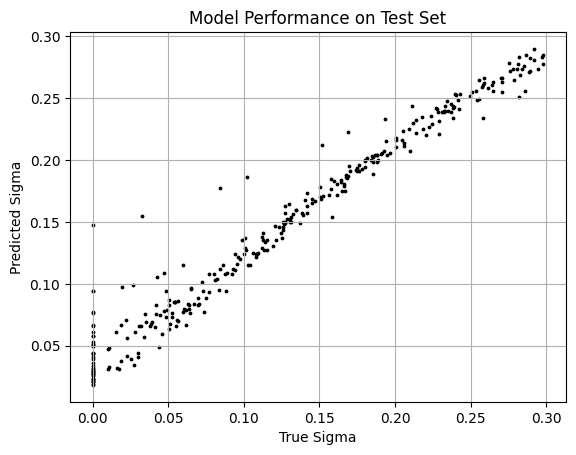

In [15]:
import matplotlib.pyplot as plt

plt.scatter(test_true_sigmas, predicted_sigmas_np, alpha=1,s= 3, color = "black")
plt.xlabel("True Sigma")
plt.ylabel("Predicted Sigma")
plt.title("Model Performance on Test Set")
plt.grid(True)
plt.show()


In [16]:
def predict_from_tensor(model, image_tensor,device='cpu'):
    """
    Predict sigma from a preprocessed image tensor
    """
    model.eval()
    
      # Ensure correct dtype
    image_tensor = image_tensor.float()  # Convert to float32

    # Ensure correct shape [1, 1, H, W]
    if image_tensor.dim() == 2:  # [H, W]
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.dim() == 3:  # [1, H, W] or [C, H, W]
        if image_tensor.shape[0] == 1:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dim
        else:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dim
    
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        predicted_sigma = model(image_tensor)
        return predicted_sigma.cpu().item()






def test_approach_1(image_path, true_sigma_normalized=0.1):
    """Add noise to normalized image, predict, then convert back"""
    
    # Load and preprocess image (same as training)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_float = img.astype(np.float32) / 255.0
    
    # Store original stats for conversion
    original_mean = np.mean(img_float)
    original_std = np.std(img_float)
    
    # Z-score normalize
    img_normalized = (img_float - original_mean) / original_std
    
    # Add noise at NORMALIZED scale
    noise = np.random.normal(0, true_sigma_normalized, img_normalized.shape)
    noisy_normalized = img_normalized + noise
    
    # Downsample for model input
    noisy_downsampled = cv2.resize(noisy_normalized, (256, 256), interpolation=cv2.INTER_AREA)
    
    # Get NN prediction (in normalized scale)
    predicted_sigma_normalized = predict_from_tensor(model, torch.tensor(noisy_downsampled))
    
    # Convert BOTH true and predicted sigmas to pixel scale
    true_sigma_pixels = true_sigma_normalized * original_std * 255
    predicted_sigma_pixels = predicted_sigma_normalized * original_std * 255
    
    return {
        'true_sigma_normalized': true_sigma_normalized,
        'true_sigma_pixels': true_sigma_pixels,
        'predicted_sigma_normalized': predicted_sigma_normalized,
        'predicted_sigma_pixels': predicted_sigma_pixels,
        'original_std': original_std
    }

In [24]:
test_approach_1('small_test/Te-gl_0038.jpg', true_sigma_normalized=0.2)

{'true_sigma_normalized': 0.2,
 'true_sigma_pixels': 8.788776397705078,
 'predicted_sigma_normalized': 0.20811814069747925,
 'predicted_sigma_pixels': 9.145519014481351,
 'original_std': 0.17232895}

In [22]:
img = cv2.imread('small_test/Te-gl_0038.jpg', cv2.IMREAD_GRAYSCALE)
noisy = add_noise(img, sigma=8.7)

estimate_noise_mad(noisy, use_highpass=True, sigma=8.7)

13.177641775308963

Model loaded on device: cpu
Running simple simulation with 100 trials
NN sigma range (normalized): 0.101 - 0.297
MAD sigma range (pixels): 4.50 - 12.94

Processing trials...
  Trial  1/100
    NN: true=7.7, pred=8.1
    MAD: true=4.7, est=6.8
  Trial  2/100
    NN: true=12.8, pred=12.2
    MAD: true=9.9, est=12.0
  Trial  3/100
    NN: true=10.8, pred=10.8
    MAD: true=7.2, est=9.3
  Trial  4/100
    NN: true=9.7, pred=9.9
    MAD: true=8.8, est=11.0
  Trial  5/100
    NN: true=5.8, pred=6.3
    MAD: true=12.3, est=14.3
  Trial  6/100
    NN: true=5.8, pred=6.3
    MAD: true=6.6, est=8.8
  Trial  7/100
    NN: true=4.9, pred=5.5
    MAD: true=8.0, est=10.1
  Trial  8/100
    NN: true=12.0, pred=11.7
    MAD: true=11.0, est=13.1
  Trial  9/100
    NN: true=9.7, pred=9.9
    MAD: true=6.4, est=8.6
  Trial 10/100
    NN: true=10.6, pred=10.6
    MAD: true=5.1, est=7.3
  Trial 11/100
    NN: true=4.6, pred=5.2
    MAD: true=6.9, est=9.1
  Trial 12/100
    NN: true=12.9, pred=12.3
    MAD:

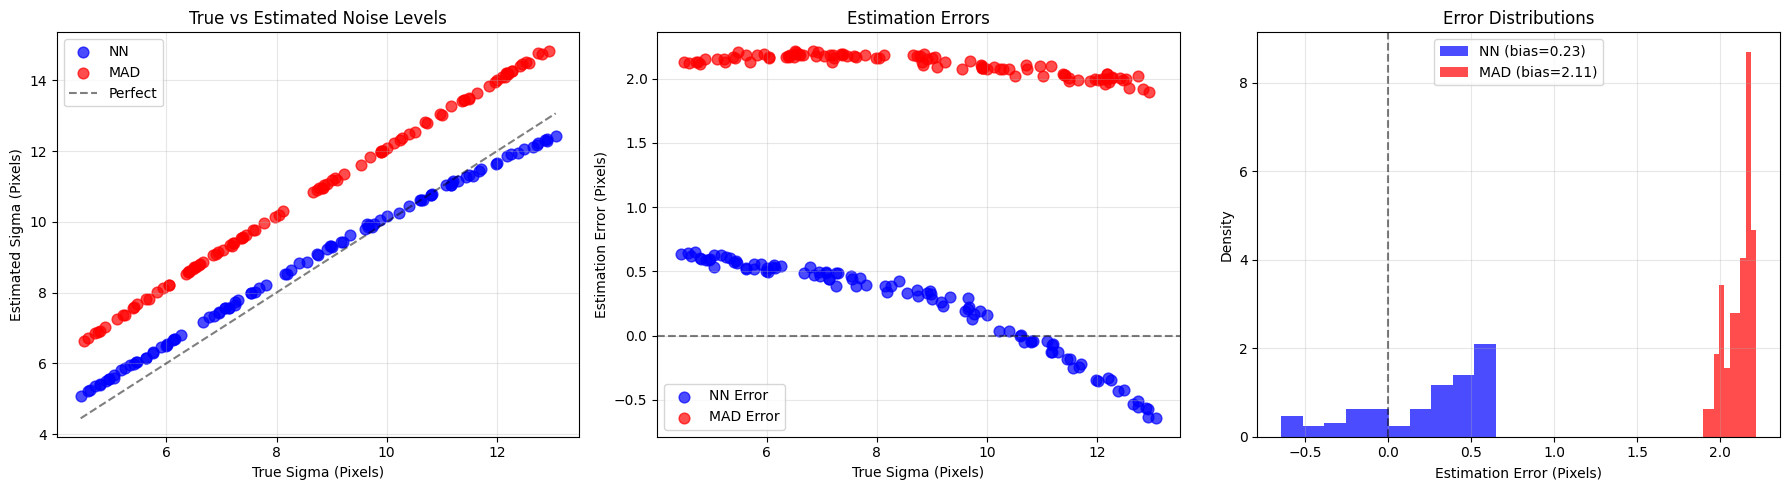

Simple simulation completed!


In [ ]:
import numpy as np
import pandas as pd
import torch
from scipy.ndimage import gaussian_filter
import cv2
import matplotlib.pyplot as plt
import random

def predict_from_tensor(model, image_tensor, device='cuda'):
    """Predict sigma from a preprocessed image tensor"""
    model.eval()
    
    # Ensure correct dtype and shape
    image_tensor = image_tensor.float()
    if image_tensor.dim() == 2:
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.dim() == 3:
        if image_tensor.shape[0] == 1:
            image_tensor = image_tensor.unsqueeze(0)
        else:
            image_tensor = image_tensor.unsqueeze(0)
    
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        predicted_sigma = model(image_tensor)
        return predicted_sigma.cpu().item()

def simple_mad_estimate(image):
    """Proper MAD estimation - first isolate noise, then apply MAD"""
    from scipy.ndimage import gaussian_filter
    
    # Step 1: Remove signal content with Gaussian smoothing
    smooth = gaussian_filter(image, sigma=3)
    
    # Step 2: Get residuals (should be mostly noise)
    residual = image - smooth
    
    # Step 3: Apply MAD to residuals
    median_residual = np.median(residual)
    mad = np.median(np.abs(residual - median_residual))
    
    # Step 4: Scale to standard deviation
    sigma_est = 1.4826 * mad
    
    return sigma_est

def test_nn_approach(model, image_path, true_sigma_normalized, device='cuda'):
    """Get NN prediction for normalized sigma"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_float = img.astype(np.float32) / 255.0
    
    # Get stats for normalization
    original_mean = np.mean(img_float)
    original_std = np.std(img_float)
    
    # Z-score normalize
    img_normalized = (img_float - original_mean) / original_std
    
    # Add noise in normalized scale
    noise = np.random.normal(0, true_sigma_normalized, img_normalized.shape)
    noisy_normalized = img_normalized + noise
    
    # Downsample for model
    noisy_downsampled = cv2.resize(noisy_normalized, (256, 256), interpolation=cv2.INTER_AREA)
    
    # Get NN prediction
    predicted_sigma_normalized = predict_from_tensor(model, torch.tensor(noisy_downsampled), device=device)
    
    # Convert to pixel scale
    true_sigma_pixels = true_sigma_normalized * original_std * 255
    predicted_sigma_pixels = predicted_sigma_normalized * original_std * 255
    
    # Create noisy image in pixel scale for MAD
    noisy_pixels = (noisy_normalized * original_std + original_mean) * 255
    
    return {
        'true_sigma_pixels': true_sigma_pixels,
        'predicted_sigma_pixels': predicted_sigma_pixels,
        'noisy_image_pixels': noisy_pixels
    }

def simple_simulation(model, image_path, device='cuda', n_trials=30):
    """Simple simulation comparing NN and MAD"""
    
    # Set seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Sample normalized sigma values (0.1, 0.3) for NN
    nn_sigmas_normalized = np.random.uniform(0.1, 0.3, n_trials)
    
    # Sample pixel sigma values (4.44, 13.068) for MAD comparison
    mad_sigmas_pixels = np.random.uniform(4.44, 13.068, n_trials)
    
    print(f"Running simple simulation with {n_trials} trials")
    print(f"NN sigma range (normalized): {nn_sigmas_normalized.min():.3f} - {nn_sigmas_normalized.max():.3f}")
    print(f"MAD sigma range (pixels): {mad_sigmas_pixels.min():.2f} - {mad_sigmas_pixels.max():.2f}")
    
    # Load base image for pixel-scale noise
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_float = img.astype(np.float32) / 255.0
    img_pixels = img_float * 255
    
    results = {
        'Trial': [],
        'NN_True_Sigma_Normalized': [],
        'NN_True_Sigma_Pixels': [],
        'NN_Predicted_Pixels': [],
        'MAD_True_Sigma_Pixels': [],
        'MAD_Estimated_Pixels': []
    }
    
    print("\nProcessing trials...")
    
    for i in range(n_trials):
        print(f"  Trial {i+1:2d}/{n_trials}")
        
        try:
            # NN test
            nn_sigma_norm = nn_sigmas_normalized[i]
            nn_result = test_nn_approach(model, image_path, nn_sigma_norm, device)
            
            # MAD test - add noise directly to pixel image
            mad_sigma_pixels = mad_sigmas_pixels[i]
            noise_pixels = np.random.normal(0, mad_sigma_pixels, img_pixels.shape)
            noisy_pixels_mad = img_pixels + noise_pixels
            mad_estimate = simple_mad_estimate(noisy_pixels_mad)
            
            # Store results
            results['Trial'].append(i + 1)
            results['NN_True_Sigma_Normalized'].append(nn_sigma_norm)
            results['NN_True_Sigma_Pixels'].append(nn_result['true_sigma_pixels'])
            results['NN_Predicted_Pixels'].append(nn_result['predicted_sigma_pixels'])
            results['MAD_True_Sigma_Pixels'].append(mad_sigma_pixels)
            results['MAD_Estimated_Pixels'].append(mad_estimate)
            
            print(f"    NN: true={nn_result['true_sigma_pixels']:.1f}, pred={nn_result['predicted_sigma_pixels']:.1f}")
            print(f"    MAD: true={mad_sigma_pixels:.1f}, est={mad_estimate:.1f}")
            
        except Exception as e:
            print(f"    Error: {e}")
            # Store NaN for failed trials
            results['Trial'].append(i + 1)
            for key in ['NN_True_Sigma_Normalized', 'NN_True_Sigma_Pixels', 'NN_Predicted_Pixels', 
                       'MAD_True_Sigma_Pixels', 'MAD_Estimated_Pixels']:
                results[key].append(np.nan)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Calculate errors
    df['NN_Error'] = df['NN_Predicted_Pixels'] - df['NN_True_Sigma_Pixels']
    df['MAD_Error'] = df['MAD_Estimated_Pixels'] - df['MAD_True_Sigma_Pixels']
    df['NN_Relative_Error'] = (df['NN_Error'] / df['NN_True_Sigma_Pixels']) * 100
    df['MAD_Relative_Error'] = (df['MAD_Error'] / df['MAD_True_Sigma_Pixels']) * 100
    
    # Print results
    print("\n" + "="*60)
    print("SIMPLE SIMULATION RESULTS")
    print("="*60)
    
    print(f"\nNN Statistics:")
    print(f"  Mean Absolute Error: {np.nanmean(np.abs(df['NN_Error'])):.3f}")
    print(f"  Bias: {np.nanmean(df['NN_Error']):.3f}")
    print(f"  Mean Relative Error: {np.nanmean(df['NN_Relative_Error']):.1f}%")
    
    print(f"\nMAD Statistics:")
    print(f"  Mean Absolute Error: {np.nanmean(np.abs(df['MAD_Error'])):.3f}")
    print(f"  Bias: {np.nanmean(df['MAD_Error']):.3f}")
    print(f"  Mean Relative Error: {np.nanmean(df['MAD_Relative_Error']):.1f}%")
    
    # Check overestimation
    nn_overest = np.sum(df['NN_Error'] > 0)
    mad_overest = np.sum(df['MAD_Error'] > 0)
    print(f"\nOverestimation frequency:")
    print(f"  NN: {nn_overest}/{len(df)} ({nn_overest/len(df)*100:.1f}%)")
    print(f"  MAD: {mad_overest}/{len(df)} ({mad_overest/len(df)*100:.1f}%)")
    
    # Display table
    print(f"\nDetailed Results:")
    display_df = df[['Trial', 'NN_True_Sigma_Pixels', 'NN_Predicted_Pixels', 
                    'MAD_True_Sigma_Pixels', 'MAD_Estimated_Pixels']].round(2)
    print(display_df.to_string(index=False))
    
    return df

def plot_simple_results(df, save_path=None):
    """Create simple comparison plots"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: True vs Predicted scatter
    axes[0].scatter(df['NN_True_Sigma_Pixels'], df['NN_Predicted_Pixels'], 
                   alpha=0.7, color='blue', label='NN', s=60)
    axes[0].scatter(df['MAD_True_Sigma_Pixels'], df['MAD_Estimated_Pixels'], 
                   alpha=0.7, color='red', label='MAD', s=60)
    
    # Perfect estimation line
    all_true = np.concatenate([df['NN_True_Sigma_Pixels'].dropna(), df['MAD_True_Sigma_Pixels'].dropna()])
    min_val, max_val = all_true.min(), all_true.max()
    axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect')
    
    axes[0].set_xlabel('True Sigma (Pixels)')
    axes[0].set_ylabel('Estimated Sigma (Pixels)')
    axes[0].set_title('True vs Estimated Noise Levels')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Error comparison
    axes[1].scatter(df['NN_True_Sigma_Pixels'], df['NN_Error'], 
                   alpha=0.7, color='blue', label='NN Error', s=60)
    axes[1].scatter(df['MAD_True_Sigma_Pixels'], df['MAD_Error'], 
                   alpha=0.7, color='red', label='MAD Error', s=60)
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('True Sigma (Pixels)')
    axes[1].set_ylabel('Estimation Error (Pixels)')
    axes[1].set_title('Estimation Errors')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Error distributions
    axes[2].hist(df['NN_Error'].dropna(), alpha=0.7, bins=10, 
                label=f'NN (bias={np.nanmean(df["NN_Error"]):.2f})', color='blue', density=True)
    axes[2].hist(df['MAD_Error'].dropna(), alpha=0.7, bins=10, 
                label=f'MAD (bias={np.nanmean(df["MAD_Error"]):.2f})', color='red', density=True)
    axes[2].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('Estimation Error (Pixels)')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Error Distributions')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ImprovedNoiseRegressor().to(device)
    model.load_state_dict(torch.load('best_model2.pt'))
    model.eval()
    
    print(f"Model loaded on device: {device}")
    
    # Run simple simulation
    results = simple_simulation(
        model=model,
        image_path='small_test/Te-gl_0038.jpg',  # UPDATE THIS
        device=device,
        n_trials=100
    )
    
    # Plot results
    plot_simple_results(results, save_path='simple_noise_comparison.png')
    
    print("Simple simulation completed!")